# Uniformity Testing:

In [1]:
import math 
from scipy.stats import randint
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
#from tqdm import tnrange

In [482]:
#GLOBAL VARIABLES
#C=... #large constant
#n=99
epsilon=0.3
delta=0.3
#s=(C*math.sqrt(n))/(eplsilon**4)
#s=1464 # for n=10000
#s=100

#t=math.comb(s,2)*((1+2*(epsilon**2))/n)
#t=120 # for n=10000
#t=584

In [2]:
def sample_Dfar1():
    # Choose epsilon*n items to have higher probability
    S = set(random.sample(range(n), int(epsilon * n)))

    # Precompute probabilities
    prob = [0] * n
    for i in range(n):
        if i in S:
            prob[i] = (1/n) + (2*epsilon/n)
        else:
            prob[i] = (1/n) - (2*epsilon/(n*(1-epsilon)))
    
    # Normalize (optional tiny correction for numerical stability)
    total_prob = sum(prob)
    prob = [p/total_prob for p in prob]

    # Use random.choices to sample according to distribution
    return random.choices(range(1, n+1), weights=prob, k=1)[0]


def sample_Dfar_easy():
    # Create the D_far probability vector once
    S = set(random.sample(range(n), int(epsilon * n)))
    
    #prob = [0] * n
    prob=np.zeros(n)
    for i in range(n):
        if i in S:
            prob[i] = (1/n) + (2*epsilon/n)
        else:
            prob[i] = (1/n) - (2*epsilon/(n*(1-epsilon)))
    
    # Normalize just in case (tiny numerical errors)
    #total_prob = sum(prob)
    #prob = [p/total_prob for p in prob]
    prob /=prob.sum()
    
    return prob


In [3]:
def paninski_dfar():
    """
    Implements Paninski's hard ε-far distribution from Section 3:
    q(i) = (1 + ε z_{i/2}) / m,   if i is even
           (1 - ε z_{(i+1)/2}) / m, if i is odd
    """

    assert n % 2 == 0, "m must be even for Paninski's construction."

    half_n = n // 2
    z = np.random.choice([-1, 1], size=half_n+1)  # z_j ∈ {−1, +1}

    q = np.zeros(n)
    for i in range(n):
        if i % 2 == 0:  # even index
            idx = i // 2
            q[i] = (1 + epsilon * z[idx]) / n
        else:  # odd index
            idx = (i + 1) // 2
            q[i] = (1 - epsilon * z[idx]) / n

    # Normalize for safety (though it should already sum to 1)
    q /= q.sum()
    return q

In [4]:
def sample_Dfar_many(prob, n, s):
    return random.choices(range(1, n+1), weights=prob, k=s)

In [5]:
def compute_Y(samples):
    Y_ij=[]
    
    for i in range(len(samples)):
        for j in range(i+1,len(samples)):
            Y_ij+=[samples[i]==samples[j]]
    
    return sum(Y_ij)    


In [6]:
def uniformity_test(samples):
    
    Y=compute_Y(samples)
    
    print(f"Y is {Y}")
    print(f"t is {t}")
    
    if Y >= t:
        return False
    else:
        return True
    

In [7]:
def plot_collision_distributions(num_collisions_uniform, num_collisions_Dfar, threshold_t=None):
    plt.figure(figsize=(10,6))
    
    # Plot histograms
    plt.hist(num_collisions_uniform, bins=30, alpha=0.6, label='Uniform', color='blue', density=True)
    plt.hist(num_collisions_Dfar, bins=30, alpha=0.6, label='D_far', color='red', density=True)
    
    # Plot threshold if given
    if threshold_t is not None:
        plt.axvline(threshold_t, color='black', linestyle='dashed', label=f'Threshold t = {threshold_t:.2f}')
    
    plt.xlabel('Number of Collisions')
    plt.ylabel('Density')
    plt.title('Collision Distributions for Uniform vs D_far')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
def find_threshold(num_collisions_uniform, num_collisions_Dfar, delta):
    num_samples = len(num_collisions_uniform)
    
    # Find (1-delta) percentile for uniform
    idx_u = int(np.floor((1 - delta) * num_samples))
    threshold_u = num_collisions_uniform[idx_u]
    
    # Find (delta) percentile for Dfar
    idx_d = int(np.floor(delta * num_samples))
    threshold_d = num_collisions_Dfar[idx_d]
    
    # Check if separation is possible
    if threshold_u < threshold_d:
        # You can choose any t between threshold_u and threshold_d
        t_test = (threshold_u + threshold_d) / 2
        return t_test
    else:
        return None  # Means s is too small, need larger s

In [9]:
def find_s_and_t(n, epsilon, delta, sample_Dfar, s_test):
    #s_test = 500  # initial guess
    while True:
        
        num_collisions_uniform = []
        num_collisions_Dfar = []
        
        prob_Dfar = sample_Dfar()
        
        for _ in range(100):  # 100 repetitions (you can increase it)
            samples_from_uniform = list(randint.rvs(1, n+1, size=s_test))
            samples_from_Dfar = sample_Dfar_many(prob_Dfar, n, s_test)
            
            num_collisions_uniform.append(compute_Y(samples_from_uniform))
            num_collisions_Dfar.append(compute_Y(samples_from_Dfar))
        
        num_collisions_uniform.sort()
        num_collisions_Dfar.sort()
        
        t_test = find_threshold(num_collisions_uniform, num_collisions_Dfar, delta)
        
        print("Finished")
        
        if t_test is not None:
            return s_test, t_test  # success: found good s and t
        else:
            s_test = int(s_test * 1.1)  # increase s and try again
    

In [484]:
n=1000
def main0():
    print(find_s_and_t(n, epsilon=0.2, delta=0.1))
    

In [485]:
main0()

(500, 205.0)


In [460]:
s_test=449
num_collisions_uniform = []
num_collisions_Dfar = []

prob_Dfar = sample_Dfar_easy()

for _ in range(100):  # 100 repetitions (you can increase it)
    samples_from_uniform = list(randint.rvs(1, n+1, size=s_test))
    samples_from_Dfar = sample_Dfar_many(prob_Dfar, n, s_test)

    num_collisions_uniform.append(compute_Y(samples_from_uniform))
    num_collisions_Dfar.append(compute_Y(samples_from_Dfar))

num_collisions_uniform.sort()
num_collisions_Dfar.sort()

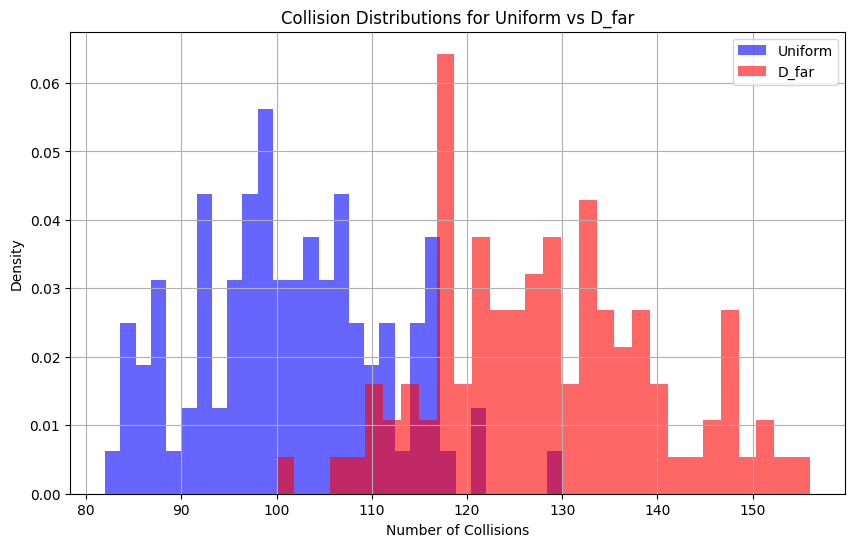

In [461]:
plot_collision_distributions(num_collisions_uniform, num_collisions_Dfar, threshold_t=None)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def find_auto_threshold(num_collisions_uniform, num_collisions_Dfar, plot=True):
    # Kernel density estimation
    kde_u = gaussian_kde(num_collisions_uniform)
    kde_d = gaussian_kde(num_collisions_Dfar)
    
    # Create a fine grid over the collision values
    x_grid = np.linspace(min(min(num_collisions_uniform), min(num_collisions_Dfar)),
                         max(max(num_collisions_uniform), max(num_collisions_Dfar)), 1000)
    
    u_density = kde_u(x_grid)
    d_density = kde_d(x_grid)
    
    # Find where Uniform's density crosses below Dfar's density
    crossover_indices = np.where(u_density < d_density)[0]
    
    if len(crossover_indices) == 0:
        print("No clear crossover found — maybe s is too small?")
        return None
    
    # Pick the first crossover point
    crossover_idx = crossover_indices[0]
    threshold_t = x_grid[crossover_idx]
    
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(x_grid, u_density, label='Uniform density', color='blue')
        plt.plot(x_grid, d_density, label='D_far density', color='red')
        plt.axvline(threshold_t, color='black', linestyle='dashed', label=f'Suggested t = {threshold_t:.2f}')
        plt.xlabel('Number of Collisions')
        plt.ylabel('Density')
        plt.title('Density Curves and Automatic Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return threshold_t

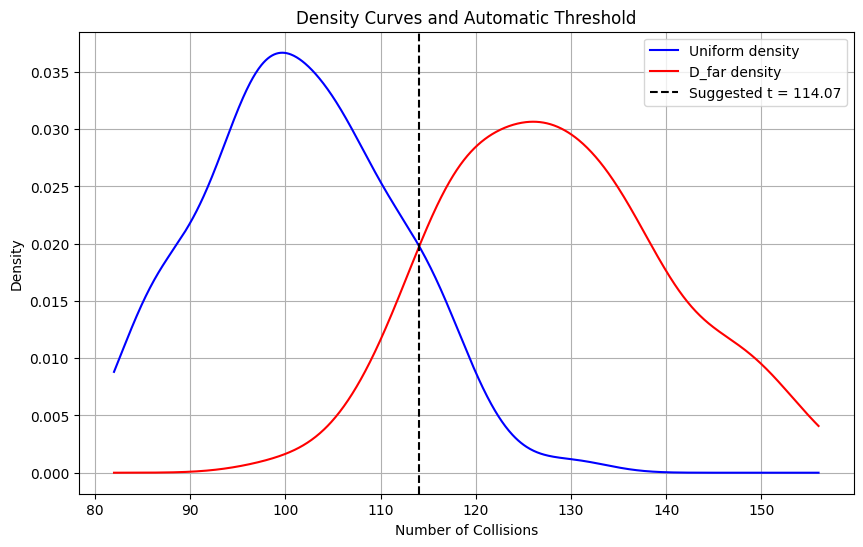

In [463]:
t_test1 = find_auto_threshold(num_collisions_uniform, num_collisions_Dfar)

In [464]:
t_test1

114.07407407407408

In [362]:
df=pd.read_csv("USD_EUR.csv")
print(df.shape)

(2677, 7)


In [363]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,04/28/2025,0.8790,0.8813,0.8815,0.8785,NaN,-0.28%
1,04/27/2025,0.8814,0.8797,0.8817,0.8796,NaN,0.18%
2,04/25/2025,0.8798,0.8780,0.8838,0.8776,NaN,0.21%
3,04/24/2025,0.8780,0.8838,0.8839,0.8773,NaN,-0.63%
4,04/23/2025,0.8836,0.8756,0.8844,0.8741,NaN,0.91%


In [11]:
def get_last_digit(x):
    
    decimals=str(x).split(".")
    if len(decimals)==1:
        return "0"
    
    decimal=decimals[-1]
    
    #.7000=>0.7
    if len(decimal)==1:
        return decimal+'000'
    
    #.7700=>0.77
    elif len(decimal)==2:
        return decimal+'00'
    
    #.7770=>0.777
    elif len(decimal)==3:
        return decimal + '0'
    
    else:
        return decimal 
    

In [394]:
def main1(last_digit, sample_size):
    
    df=pd.read_csv("USD_EUR.csv")
    print(df.shape)

    usd_eur_price_lastNdigit=df["Price"].apply(lambda x: int(get_last_digit(x)[-1*last_digit:]))

    print("Before Sample")
    print("number, count")
    print(usd_eur_price_lastNdigit.value_counts())
    
    usd_eur_price_lastNdigit=random.sample(list(usd_eur_price_lastNdigit.values), sample_size)
    
    print("After Sample")
    print("number, count")
    print(Counter(usd_eur_price_lastNdigit))
   
    
    print(f"This dataset is uniform?: {uniformity_test(usd_eur_price_lastNdigit)}")
    
    

In [465]:
n=10
s=100
t=540

main1(last_digit=1,sample_size=s)

(2677, 7)
Before Sample
number, count
8    288
4    282
3    275
0    274
1    271
2    265
7    263
5    258
9    254
6    247
Name: Price, dtype: int64
After Sample
number, count
Counter({6: 14, 4: 13, 0: 12, 5: 12, 8: 10, 2: 9, 3: 8, 1: 8, 7: 7, 9: 7})
Y is 480
t is 540
This dataset is uniform?: True


In [467]:
#Run this multiple times because it sometimes return True sometimes False
n=100
s=160
t=142

main1(last_digit=2, sample_size=s)

(2677, 7)
Before Sample
number, count
28    44
63    40
98    36
90    36
14    36
      ..
55    18
97    15
92    15
48    15
36    14
Name: Price, Length: 100, dtype: int64
After Sample
number, count
Counter({40: 6, 67: 5, 8: 4, 5: 4, 12: 4, 22: 4, 98: 4, 15: 4, 32: 4, 9: 3, 41: 3, 0: 3, 92: 3, 16: 3, 35: 3, 51: 3, 29: 3, 17: 3, 14: 3, 66: 3, 72: 3, 75: 2, 74: 2, 81: 2, 60: 2, 77: 2, 99: 2, 82: 2, 69: 2, 13: 2, 26: 2, 37: 2, 79: 2, 59: 2, 30: 2, 87: 2, 62: 2, 33: 2, 54: 2, 95: 2, 42: 2, 65: 2, 50: 2, 61: 2, 68: 2, 28: 2, 93: 2, 83: 1, 73: 1, 34: 1, 94: 1, 25: 1, 11: 1, 2: 1, 89: 1, 21: 1, 20: 1, 39: 1, 90: 1, 64: 1, 55: 1, 91: 1, 70: 1, 1: 1, 3: 1, 56: 1, 24: 1, 88: 1, 6: 1, 38: 1, 10: 1, 44: 1, 19: 1, 46: 1, 85: 1, 7: 1, 31: 1, 96: 1, 27: 1, 52: 1})
Y is 129
t is 142
This dataset is uniform?: True


In [471]:
#Run this multiple times because it sometimes return True sometimes False
n=1000
s=449
t=113

main1(last_digit=3, sample_size=s)

(2677, 7)
Before Sample
number, count
445    9
218    9
814    9
228    9
230    8
      ..
396    1
299    1
388    1
303    1
355    1
Name: Price, Length: 905, dtype: int64
After Sample
number, count
Counter({208: 4, 209: 4, 422: 4, 463: 4, 346: 3, 829: 3, 521: 3, 86: 3, 251: 3, 105: 3, 857: 3, 517: 3, 866: 3, 189: 3, 392: 3, 798: 3, 151: 2, 278: 2, 474: 2, 249: 2, 74: 2, 96: 2, 790: 2, 277: 2, 931: 2, 16: 2, 158: 2, 164: 2, 981: 2, 202: 2, 302: 2, 42: 2, 614: 2, 631: 2, 107: 2, 228: 2, 170: 2, 851: 2, 477: 2, 940: 2, 221: 2, 942: 2, 539: 2, 476: 2, 319: 2, 983: 2, 509: 2, 424: 2, 527: 2, 188: 2, 786: 2, 198: 2, 602: 2, 732: 2, 836: 2, 390: 2, 135: 2, 204: 2, 807: 2, 267: 2, 227: 2, 820: 2, 468: 2, 433: 2, 909: 2, 889: 2, 370: 2, 77: 2, 479: 2, 913: 2, 230: 2, 154: 2, 520: 1, 615: 1, 301: 1, 80: 1, 777: 1, 409: 1, 379: 1, 513: 1, 223: 1, 5: 1, 879: 1, 275: 1, 64: 1, 993: 1, 582: 1, 196: 1, 712: 1, 387: 1, 564: 1, 901: 1, 924: 1, 471: 1, 967: 1, 420: 1, 814: 1, 859: 1, 127: 1, 113: 1

In [472]:
def main():
    
    #collect s samples from Uniform Distribution
    #samples_from_uniform=[sample_uniform() for _ in range(s)]
    samples_from_uniform=list(randint.rvs(1, n+1, size=s))
    
    prob_Dfar = sample_Dfar_easy()
    
    #collect s samples from Dfar 
    samples_from_Dfar=sample_Dfar_many(prob_Dfar, n, s)
    
    #Uniformity testing on Uniform Distribution
    is_U_uniform=uniformity_test(samples_from_uniform)
    
    #Uniformity testing on Uniform Distribution
    is_Dfar_uniform=uniformity_test(samples_from_Dfar)
    
    print("Uniform distribution is uniform?", is_U_uniform)
    print("D_far distribution is uniform?", is_Dfar_uniform)
    
    return 
    

In [478]:
n=10000
s=1464
t=120

main()

Y is 109
t is 120
Y is 128
t is 120
Uniform distribution is uniform? True
D_far distribution is uniform? False


In [481]:
3//2

1

## For easy Dfar: Dfar1

In [11]:
old_uniform_easy_s=[]

In [12]:
epsilon=0.2
delta=0.1

In [13]:
n=10000
def main0():
    # 16 seconds for one while loop starting from 1000
    # for (1610, 147.5) 2.5 minutes
    print(find_s_and_t(n, epsilon=0.2, delta=0.1, sample_Dfar=sample_Dfar_easy, s_test=1000))

In [14]:
main0()

Finished
Finished
Finished
Finished
Finished
Finished
(1610, 147.5)


In [41]:
#STORE VALUES HERE:

for i in range(10):
    old_uniform_easy_s +=[find_s_and_t(n, epsilon=0.2, delta=0.1, sample_Dfar=sample_Dfar_easy, s_test=1000)]
    

Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished


In [30]:
s_test=1331
num_collisions_uniform = []
num_collisions_Dfar = []

prob_Dfar = sample_Dfar_easy()

for _ in range(100):  # 100 repetitions (you can increase it)
    samples_from_uniform = list(randint.rvs(1, n+1, size=s_test))
    samples_from_Dfar = sample_Dfar_many(prob_Dfar, n, s_test)

    num_collisions_uniform.append(compute_Y(samples_from_uniform))
    num_collisions_Dfar.append(compute_Y(samples_from_Dfar))

num_collisions_uniform.sort()
num_collisions_Dfar.sort()

KeyboardInterrupt: 

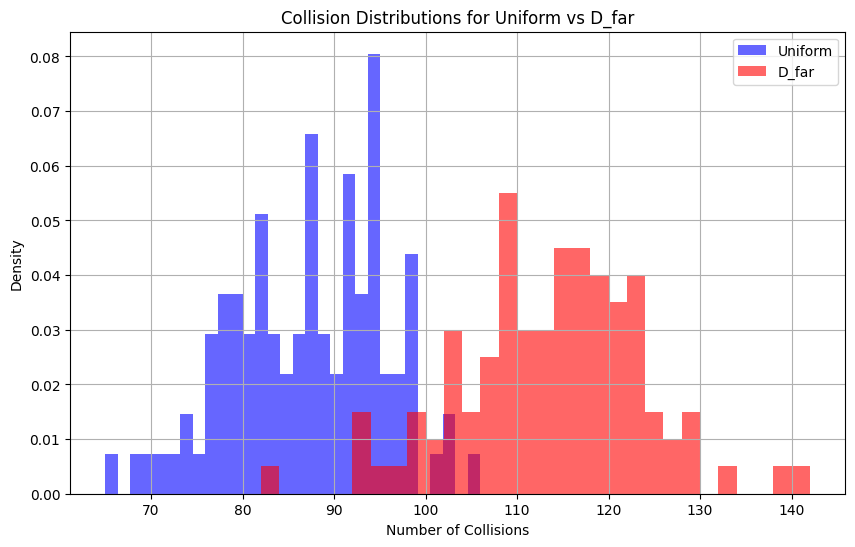

In [19]:
plot_collision_distributions(num_collisions_uniform, num_collisions_Dfar, threshold_t=None)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def find_auto_threshold(num_collisions_uniform, num_collisions_Dfar, plot=True):
    # Kernel density estimation
    kde_u = gaussian_kde(num_collisions_uniform)
    kde_d = gaussian_kde(num_collisions_Dfar)
    
    # Create a fine grid over the collision values
    x_grid = np.linspace(min(min(num_collisions_uniform), min(num_collisions_Dfar)),
                         max(max(num_collisions_uniform), max(num_collisions_Dfar)), 1000)
    
    u_density = kde_u(x_grid)
    d_density = kde_d(x_grid)
    
    # Find where Uniform's density crosses below Dfar's density
    crossover_indices = np.where(u_density < d_density)[0]
    
    if len(crossover_indices) == 0:
        print("No clear crossover found — maybe s is too small?")
        return None
    
    # Pick the first crossover point
    crossover_idx = crossover_indices[0]
    threshold_t = x_grid[crossover_idx]
    
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(x_grid, u_density, label='Uniform density', color='blue')
        plt.plot(x_grid, d_density, label='D_far density', color='red')
        plt.axvline(threshold_t, color='black', linestyle='dashed', label=f'Suggested t = {threshold_t:.2f}')
        plt.xlabel('Number of Collisions')
        plt.ylabel('Density')
        plt.title('Density Curves and Automatic Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return threshold_t

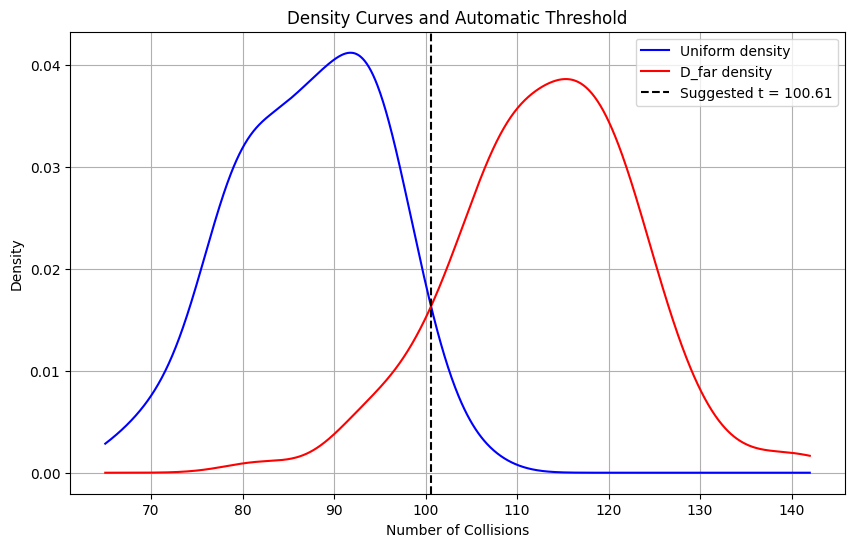

In [21]:
t_test1 = find_auto_threshold(num_collisions_uniform, num_collisions_Dfar)

In [22]:
t_test1

100.6096096096096

In [42]:
old_uniform_easy_s

[(1331, 99.5),
 (1331, 105.0),
 (1331, 100.0),
 (1464, 124.5),
 (1464, 120.0),
 (1610, 146.0),
 (1464, 121.5),
 (1331, 99.5),
 (1610, 148.0),
 (1331, 100.0)]

In [46]:
old_s_values=[pair[0] for pair in old_uniform_easy_s]

In [47]:
np.mean(old_s_values)

1426.7

In [23]:
#Doing the same thing but now trying epsilon=0.3 and delta=0.2

n=10000
def main0():
    # 16 seconds for one while loop starting from 1000
    # for (1610, 147.5) 2.5 minutes
    print(find_s_and_t(n, epsilon=0.3, delta=0.2, sample_Dfar=sample_Dfar_easy, s_test=100))

In [24]:
main0()

Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
(281, 5.5)


In [25]:
#Doing the same thing but now trying epsilon=0.3 and delta=0.2
epsilon=0.3
delta=0.2
old_uniform_easy_s1=[]

for i in range(10):
    old_uniform_easy_s1 +=[find_s_and_t(n, epsilon=0.3, delta=0.2, sample_Dfar=sample_Dfar_easy, s_test=100)]
    print("Done")
    

Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
F

In [26]:
old_uniform_easy_s1

[(256, 5.5),
 (281, 5.5),
 (256, 5.5),
 (256, 4.5),
 (256, 4.5),
 (281, 6.0),
 (309, 7.5),
 (233, 3.5),
 (233, 4.5),
 (281, 6.5)]

In [29]:
#Doing the same thing but now trying epsilon=0.25 and delta=0.15
n=10000
def main0():
    print(find_s_and_t(n, epsilon=0.25, delta=0.15, sample_Dfar=sample_Dfar_easy, s_test=100))

In [30]:
main0()

Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
(309, 6.5)


In [31]:
#Doing the same thing but now trying epsilon=0.3 and delta=0.2
epsilon=0.25
delta=0.15
old_uniform_easy_s2=[]

for i in range(10):
    old_uniform_easy_s2 +=[find_s_and_t(n, epsilon=0.25, delta=0.15, sample_Dfar=sample_Dfar_easy, s_test=100)]
    print("Done")
    

Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Done
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Fin

In [32]:
old_uniform_easy_s2

[(493, 16.5),
 (596, 23.5),
 (542, 19.5),
 (655, 26.5),
 (542, 19.5),
 (493, 15.5),
 (542, 18.5),
 (542, 18.5),
 (542, 18.5),
 (542, 18.5)]

## For Paninski's Dfar: Dfar2

In [42]:
paninski_Dfar_s=[]

In [39]:
epsilon=0.3
delta=0.3

In [40]:
n=10000
def main0_p():
    print(find_s_and_t(n, epsilon=0.3, delta=0.3, sample_Dfar=paninski_dfar, s_test=1000))

In [41]:
main0_p()

Finished
Finished
Finished
(1210, 75.5)


In [44]:
#STORE VALUES HERE:
n=10000
for i in range(10):
    paninski_Dfar_s +=[find_s_and_t(n, epsilon=0.3, delta=0.3, sample_Dfar=paninski_dfar, s_test=1000)]
    

Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished


In [45]:
paninski_Dfar_s

[(1464, 111.5),
 (1610, 134.0),
 (1948, 198.0),
 (1948, 196.5),
 (1610, 136.5),
 (1771, 163.0),
 (1771, 161.5),
 (1464, 110.5),
 (1948, 197.0),
 (1771, 166.0)]

In [85]:
s_test=3000
num_Singleton_uniform = []
num_Singleton_Dfar = []

prob_Dfar_paninski = paninski_dfar()

for _ in range(100):  # 100 repetitions (you can increase it)
    samples_from_uniform = list(randint.rvs(1, n+1, size=s_test))
    samples_from_Dfar = sample_Dfar_many(prob_Dfar_paninski, n, s_test)

    num_Singleton_uniform.append(compute_Y(samples_from_uniform))
    num_Singleton_Dfar.append(compute_Y(samples_from_Dfar))

num_Singleton_uniform.sort()
num_Singleton_Dfar.sort()

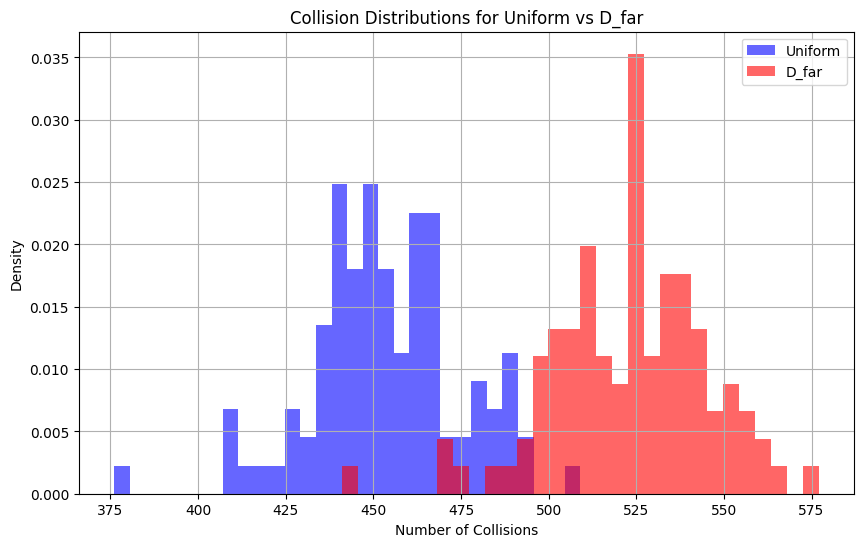

In [86]:
plot_collision_distributions(num_Singleton_uniform, num_Singleton_Dfar, threshold_t=None)

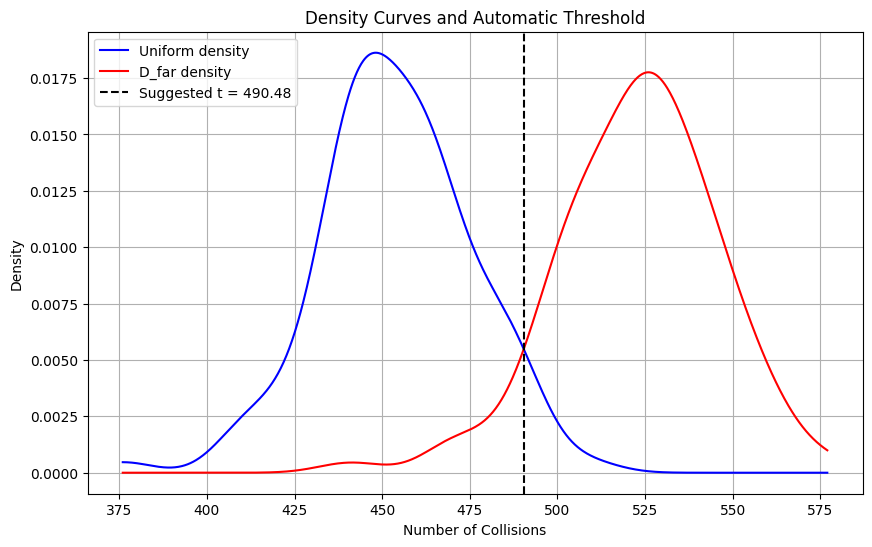

In [87]:
t_test2 = find_auto_threshold(num_Singleton_uniform, num_Singleton_Dfar)